In [1]:
from pathlib import Path
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from image_dataset import UpsampleImageDataset
from torch import nn
import torch
import yaml

with open('config.yaml', 'r') as yamlfile:
    config = yaml.safe_load(yamlfile)

model_path = Path(config['model']['path'])
learning_rate = config['train']['learning_rate']
batch_size = config['train']['batch_size']
epochs = config['train']['epochs']
model_name = config['model']['name']
dataset_path = config['dataset']['data_path']
train_path = dataset_path + '/train'
test_path = dataset_path + '/valid'
device = config['train']['device']
weight_decay = config['train']['optimizer']['weight_decay']
log_dir = config['logging']['log_dir']
in_channels = config['model']['in_channels']
hidden_layers = config['model']['hidden_layers']
res_blocks_number = config['model']['res_blocks_number']
upsample_factor = config['model']['upsample_factor']
log_append = config['logging']['append']
image_crop_size = config['train']['image_crop_size']
model_ext = config['model']['extension']
    
model_full_path = model_path / (model_name + model_ext)

# Define the transformation to be applied to each image
transform = transforms.Compose([
    #transforms.Resize((256, 256)),  # Resize the image to a fixed size
    transforms.RandomCrop((512,512)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(45),
    transforms.ToTensor()  # Convert the image to a tensor
])

# Create the ImageFolder dataset
train_data = UpsampleImageDataset(train_path, transform, upsample_factor)

test_data = UpsampleImageDataset(test_path, transform, upsample_factor)

In [2]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(dataset=train_data, 
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_data_loader = DataLoader(dataset=test_data, 
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

In [3]:
lr_batch, hr_batch = next(iter(test_data_loader))
print(lr_batch.shape)
print(hr_batch.shape)

torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 512, 512])


In [4]:
residual_upsampler_old_vgg_full_path = model_path / ('residual_upsampler_vgg_l1_80' + model_ext)
residual_upsampler_ssim_full_path = model_path / ('residual_upsampler_ssim_150' + model_ext)
residual_upsampler_vgg_mean_full_path = model_path / ('residual_upsampler_vgg_mean_380' + model_ext)

In [5]:
import torch
from residual_upsampler import ResidualUpsampler

device = "cpu"

model = ResidualUpsampler(in_channels, hidden_layers, res_blocks_number, upsample_factor)

model.load_state_dict(torch.load(f=model_full_path))

model.to(device)

model.eval()
with torch.inference_mode():
    result = model(lr_batch.to(device))

In [6]:
import torch
from residual_upsampler import ResidualUpsampler

device = "cpu"

residual_upsampler_old_vgg = ResidualUpsampler(in_channels, hidden_layers, res_blocks_number, upsample_factor)

residual_upsampler_old_vgg.load_state_dict(torch.load(f=residual_upsampler_old_vgg_full_path))

residual_upsampler_old_vgg.to(device)

residual_upsampler_old_vgg.eval()
with torch.inference_mode():
    result_residual_upsampler_old = residual_upsampler_old_vgg(lr_batch.to(device))

In [7]:
import torch
from residual_upsampler import ResidualUpsampler

device = "cpu"

residual_upsampler_ssim = ResidualUpsampler(in_channels, hidden_layers, res_blocks_number, upsample_factor)

residual_upsampler_ssim.load_state_dict(torch.load(f=residual_upsampler_ssim_full_path))

residual_upsampler_ssim.to(device)

residual_upsampler_ssim.eval()
with torch.inference_mode():
    result_residual_upsampler_ssim = residual_upsampler_ssim(lr_batch.to(device))

In [8]:
import torch
from residual_upsampler import ResidualUpsampler

device = "cpu"

residual_upsampler_vgg_mean = ResidualUpsampler(in_channels, hidden_layers, res_blocks_number, upsample_factor)

residual_upsampler_vgg_mean.load_state_dict(torch.load(f=residual_upsampler_vgg_mean_full_path))

residual_upsampler_vgg_mean.to(device)

residual_upsampler_vgg_mean.eval()
with torch.inference_mode():
    result_residual_upsampler_vgg_mean = residual_upsampler_vgg_mean(lr_batch.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

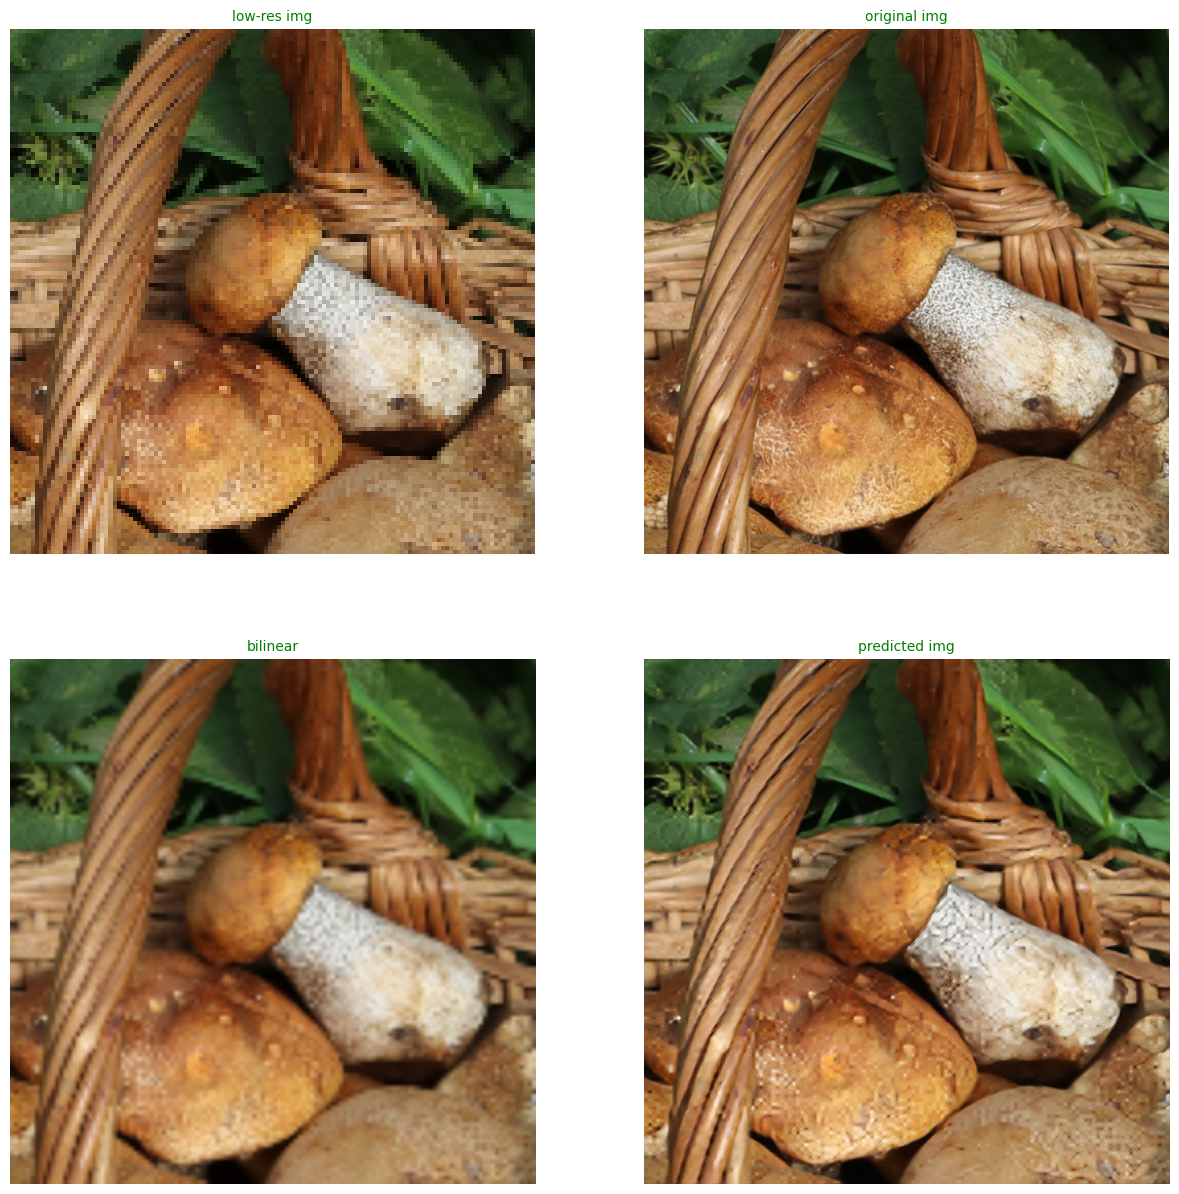

In [9]:
i = 3
y = hr_batch[i]
y_pred = result[i]
x = lr_batch[i]

upsample = nn.Upsample(scale_factor=4, mode="bilinear")

# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 2
ncols = 2

plt.subplot(nrows, ncols, 1)
plt.imshow(x.permute(1, 2, 0))
plt.title("low-res img", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 3)
plt.imshow(upsample(x.unsqueeze(0)).squeeze().permute(1, 2, 0))
plt.title("bilinear", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 4)
plt.imshow(y_pred.permute(1, 2, 0))
plt.title("predicted img", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 2)
plt.imshow(y.permute(1, 2, 0))
plt.title("original img", fontsize=10, c="g") # green text if correct
plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

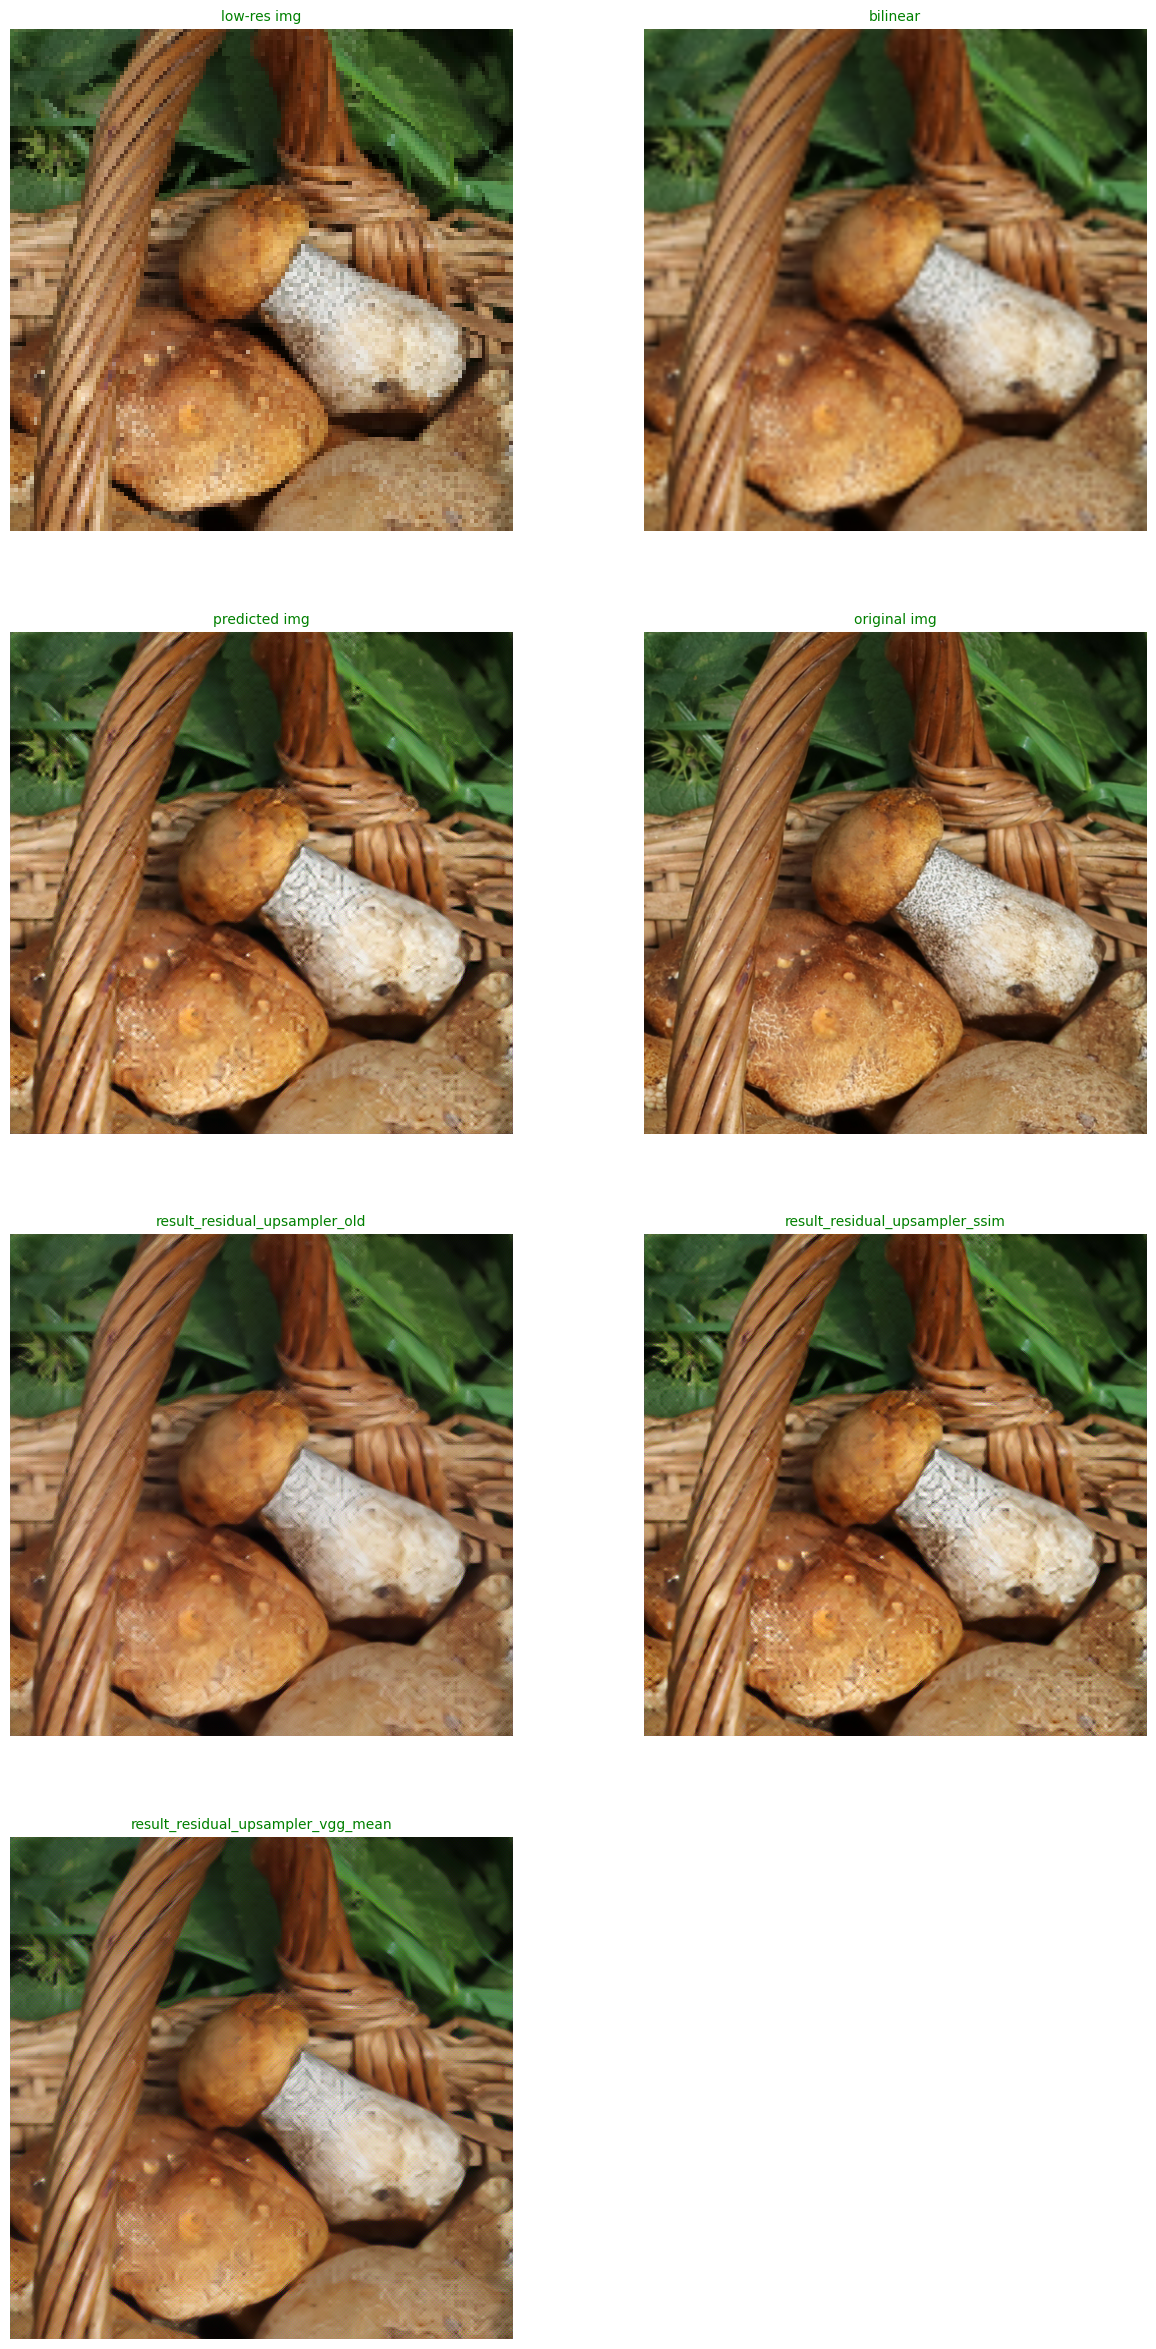

In [10]:
i = 3
y = hr_batch[i]
y_pred = result[i]
x = lr_batch[i]

upsample = nn.Upsample(scale_factor=4, mode="bilinear")

# Plot predictions
plt.figure(figsize=(15, 30))
nrows = 4
ncols = 2

plt.subplot(nrows, ncols, 1)
plt.imshow(x.permute(1, 2, 0))
plt.title("low-res img", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 2)
plt.imshow(upsample(x.unsqueeze(0)).squeeze().permute(1, 2, 0))
plt.title("bilinear", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 3)
plt.imshow(y_pred.permute(1, 2, 0))
plt.title("predicted img", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 4)
plt.imshow(y.permute(1, 2, 0))
plt.title("original img", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 5)
plt.imshow(result_residual_upsampler_old[i].permute(1, 2, 0))
plt.title("result_residual_upsampler_old", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 6)
plt.imshow(result_residual_upsampler_ssim[i].permute(1, 2, 0))
plt.title("result_residual_upsampler_ssim", fontsize=10, c="g") # green text if correct
plt.axis(False)

plt.subplot(nrows, ncols, 7)
plt.imshow(result_residual_upsampler_vgg_mean[i].permute(1, 2, 0))
plt.title("result_residual_upsampler_vgg_mean", fontsize=10, c="g") # green text if correct
plt.axis(False)

In [11]:
from torchvision.transforms import ToTensor, ToPILImage
import os

image_path = 'output'

output_image = ToPILImage()(x.squeeze(0).clamp(0, 1))

temp_image_path = os.path.join(os.path.dirname(image_path), 'lowres_image.png')
output_image.save(temp_image_path)

In [12]:
from custom_loss import VGGL1Loss
vgg_loss = VGGL1Loss('22')
for param in vgg_loss.parameters():
    print(param.shape)

d:\oleyon\github_repo\deep_learning_diploma\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\oleyon\github_repo\deep_learning_diploma\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])


In [13]:
from statistics import TrainingStatisticsLogger
import os
print(os.getcwd())
logger = TrainingStatisticsLogger()
logger.load_from_json(filename=log_dir + model_name + '_test_log.json')
logger.ssim.__len__()
loggert = TrainingStatisticsLogger()
loggert.load_from_json(filename=log_dir + model_name + '_train_log.json')
loggert.ssim.__len__()

d:\oleyon\github_repo\deep_learning_diploma\diploma


120

120


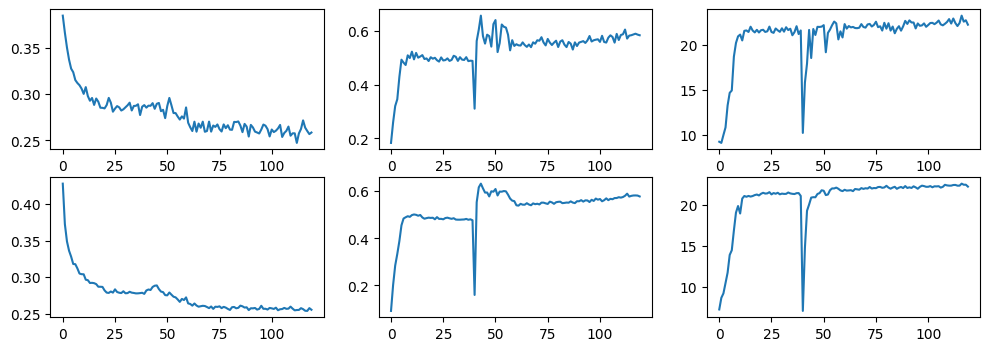

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(2,3,1)
plt.plot(logger.epoch_loss)
plt.subplot(2,3,2)
plt.plot(logger.ssim)
plt.subplot(2,3,3)
plt.plot(logger.psnr)
#plt.subplot(2,3,4)
#plt.plot(logger.epoch_training_time)
plt.subplot(2,3,4)
plt.plot(loggert.epoch_loss)
plt.subplot(2,3,5)
plt.plot(loggert.ssim)
plt.subplot(2,3,6)
plt.plot(loggert.psnr)
print(len(logger.epoch_loss))

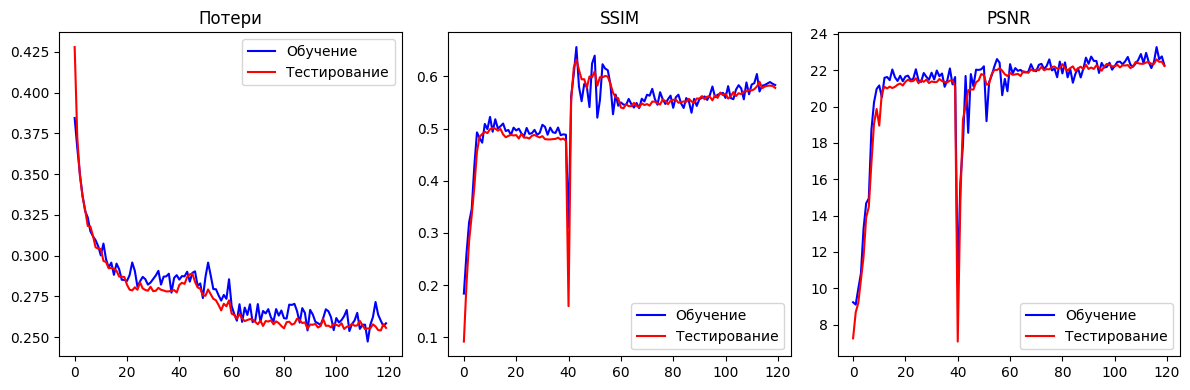

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot 1
plt.subplot(1, 3, 1)
plt.plot(logger.epoch_loss, color='blue')
plt.plot(loggert.epoch_loss, color='red')
plt.title('Потери')
plt.legend(['Обучение', 'Тестирование'])

# Plot 2
plt.subplot(1, 3, 2)
plt.plot(logger.ssim, color='blue')
plt.plot(loggert.ssim, color='red')
plt.title('SSIM')
plt.legend(['Обучение', 'Тестирование'])

# Plot 3
plt.subplot(1, 3, 3)
plt.plot(logger.psnr, color='blue')
plt.plot(loggert.psnr, color='red')
plt.title('PSNR')
plt.legend(['Обучение', 'Тестирование'])

plt.tight_layout()
plt.show()


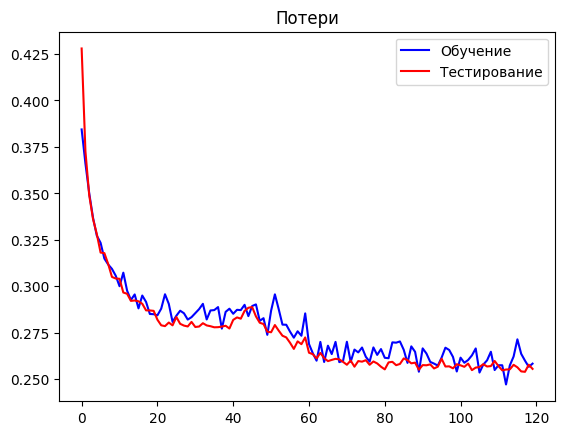

In [17]:
plt.plot(logger.epoch_loss, color='blue')
plt.plot(loggert.epoch_loss, color='red')
plt.title('Потери')
plt.legend(['Обучение', 'Тестирование'])